In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
sys.path.append('/home/jma819/post_cmfe_analysis')
#sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import itertools
import math
import warnings
import csv
warnings.filterwarnings(action='once')

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
reload(utils_jjm)
reload(dlc_utils)

<module 'dlc_utils' from '/home/jma819/post_cmfe_analysis/dlc_utils.py'>

In [3]:
#cnmfe_file_key = pd.read_csv('/volumes/My_Passport/dlc_analysis/behavcamvideos/cnmfe_file_key.csv')
cnmfe_file_key = pd.read_csv('/projects/p30771/dlc_analysis/openfield_dlc_output/cnmfe_file_key.csv')

In [4]:
#cnmfe_base_dir = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'
cnmfe_base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
wt_CNMFE_file = ['30-Mar_20_39_05_out.mat', '30-Mar_20_45_16_out.mat', '27-Feb_17_33_59_out.mat', '22-Mar_22_52_02_out.mat',
                 '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_13_27_27_out.mat',
                 '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat']

ko_CNMFE_files = ['31-Mar_13_28_15_out.mat', '29-Mar_21_42_20_out.mat', '13-Apr_17_57_40_out.mat', '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat',
                 '13-Apr_16_11_27_out.mat', '29-Mar_13_39_44_out.mat']

In [5]:
#tracking_files = ['/volumes/My_Passport/dlc_analysis/behavcamvideos/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 
tracking_files = ['/projects/p30771/dlc_analysis/openfield_dlc_output/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 

In [6]:
CNMFE_dir_paths_list = [str(cnmfe_base_dir+fname) for fname in wt_CNMFE_file]
#CNMFE_dir_paths_list

In [7]:
binning_time = 1 # seconds 
body_part_for_tracking = 'tail_base' #

grouped_raw_data = {}
success = []
failed = []
for CNMFE_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    #print(CNMFE_file)
    #print(tracking_file)
    try:
        # load cell fluorescence 
        cell_fluorescence = sio.loadmat(CNMFE_file)
        C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
        C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_z_scored = C_timedelta.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_normalized_z_scored = C_normalized.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_normalized)-1)*(1/20), len(C_normalized)), unit='s'), drop=True)
        # create tracking time deltas
        interpolated = utils_jjm.prepare_timedelta_dfs(tracking_file)
        #load spatial components by session
        com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
        cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_components)
        #C_z_scored_filtered = utils_jjm.filter_out_by_size(C_z_scored, cell_contours, for_dims, 0.6, 100)
        #store results 
        grouped_raw_data[tracking_file.split('/')[-2]] = {'C': C_timedelta, 'C_z_scored': C_z_scored, 'C_normalized': C_normalized, 'C_normalized_z_scored': C_normalized_z_scored, 
                                                          'interpolated' : interpolated, 'com' : com_df, 'spatial_components' : spatial_components, 'cell_contours': cell_contours,  
                                                         'for_dims' : for_dims}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
    except FileNotFoundError:
        failed.append(tracking_file)
    except OSError:
        failed.append(tracking_file)

## triggered averaging 

In [8]:
## combine dfs for each session to bin velocity values across dfs
#downsample
new_sampling_interval = .2
V_df = pd.concat([grouped_raw_data[session]['interpolated'].resample(str(new_sampling_interval)+'S').max() 
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
all_sessions_v_bins = pd.cut(V_df['tail_base'], bins=150)

V_df['velocity_bins'] = all_sessions_v_bins

In [9]:
filtered_for_analysis = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))


In [10]:
#bin by activity threshold (body_part, resting_time_threshold, active_time_threshold, crossing_threshold, resting_threshold, activity_threshold)
binned_velocity_df = pd.DataFrame([dlc_utils.bin_by_activity_threshold(V_df.loc[session]['tail_base'], 80, 20, 1, 2, 3)
                                for session in list(grouped_raw_data.keys())], index=list(grouped_raw_data.keys()))
binned_velocity_df = binned_velocity_df.transpose()

In [11]:
#binned_velocity_df

In [12]:
#fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True)
#ax1.plot(binned_velocity_df['GRIN013_H13_M33_S54'].values)
#ax2.plot(V_df.loc['GRIN013_H13_M33_S54']['tail_base'].values)
#plt.show()

In [13]:
## get velocity threshold indicies and select fluorescence regions
triggered_activity_across_sessions = {}
for session in list(grouped_raw_data.keys()):
    #inputs activity_threshold, resting_threshold, resting_baseline 
    crossing_indicies = utils_jjm.select_trigger_regions(binned_velocity_df[session], 0.5, 0.5, 20)
    #inputs time_to_plot
    threshold_activity = utils_jjm.average_triggered_regions(V_df.loc[session]['tail_base'].values, crossing_indicies, 80)
    cells_in_session = C_df.loc[session].dropna(axis=1)
    cell_fluorescence = cells_in_session.drop(['msCamFrame'], axis=1)
    f_threshold_activity = utils_jjm.average_triggered_regions(cell_fluorescence.mean(axis=1).values, crossing_indicies, 80)
    triggered_activity_across_sessions[session] = pd.concat([threshold_activity, f_threshold_activity], axis=1, keys=['velocity', 'fluorescence'])

In [14]:

## get velocity threshold indicies and select fluorescence regions of individual cells
indiv_cell_activity_by_session = []
for session in list(grouped_raw_data.keys()):
    #inputs activity_threshold, resting_threshold, resting_baseline 
    crossing_indicies = utils_jjm.select_trigger_regions(binned_velocity_df[session], 0.5, 0.5, 20)
    #inputs time_to_plot
    samples_to_select = 80
    threshold_activity = utils_jjm.average_triggered_regions(V_df.loc[session]['tail_base'].values, crossing_indicies, samples_to_select)
    cells_in_session = C_df.loc[session].dropna(axis=1)
    cell_fluorescence = cells_in_session.drop(['msCamFrame'], axis=1)

    activity_at_crossing =[]
    for point in crossing_indicies:
        activity_at_crossing.append(cell_fluorescence.iloc[2042-samples_to_select:2042+samples_to_select].reset_index(drop=True))
    indiv_cell_activity_by_session.append(pd.concat(activity_at_crossing, axis=1, keys=crossing_indicies))
    
triggered_activity_across_cells = pd.concat(indiv_cell_activity_by_session, axis=1, keys=grouped_raw_data.keys())    


# triggered_activity_across_sessions

In [15]:
#concat by mouse 
concacted_by_mouse = {}
for mouse in list(set([session[0:7] for session in list(triggered_activity_across_sessions.keys())])):
    dfs_by_mouse = []
    sessions = []
    for session in list(triggered_activity_across_sessions.keys()):
        if mouse in session:
            if not(triggered_activity_across_sessions[session].empty):
                means = triggered_activity_across_sessions[session].mean(axis=1, level=0)
                dfs_by_mouse.append(means)
                sessions.append(session)
    if len(dfs_by_mouse)>0:
        concacted_by_mouse[mouse] = pd.concat(dfs_by_mouse, axis=1, keys=sessions)
combined_by_mouse = pd.concat(list(concacted_by_mouse.values()), axis=1, keys=list(concacted_by_mouse.keys()))

In [16]:
combined_by_mouse_timedelta = combined_by_mouse.set_index(pd.to_timedelta(np.linspace(0, (len(combined_by_mouse)-1)*(1/5), len(combined_by_mouse)), unit='s'), drop=True)
resampled_for_plotting = combined_by_mouse_timedelta.resample('.2S').mean()

In [17]:
#resampled_for_plotting.head()

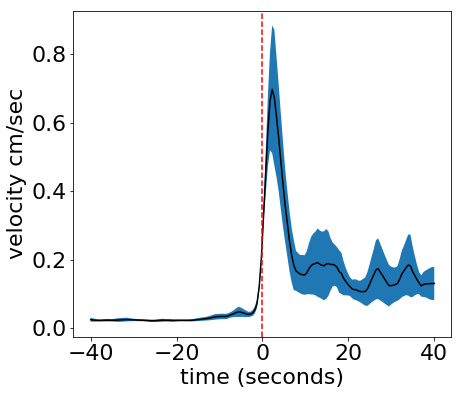

In [18]:
plt.rcParams.update({'font.size': 22})
df_to_plot = resampled_for_plotting
activity_measure = 'spatial_coordination'
x = np.linspace(-(len(df_to_plot)/2)*.5, (len(df_to_plot)/2)*.5, len(df_to_plot))
scale_f = 0.0868
mean=df_to_plot.mean(axis=1, level=2)['velocity'].values*scale_f
plt.plot(x, df_to_plot.mean(axis=1, level=2)['velocity'].values*scale_f, color='k')
std_error = ((df_to_plot.std(axis=1, level=2)['velocity'])/math.sqrt(df_to_plot.mean(axis=1, level=0).shape[1]))*scale_f
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.set_ylabel('velocity cm/sec')
ax.set_xlabel('time (seconds)')
ax.axvline(x=(0), linestyle='--', color='r')
fig = plt.gcf()
fig.set_size_inches(7, 6)
#fig.draw()
#fig.savefig('/home/jma819/presentation_files/wt_velocity_spatial_coord_triggered.svg', transparent=True)
fig.subplots_adjust(left=0.15)
fig.savefig('/home/jma819/presentation_files/v_triggered.pdf', transparent=True)
plt.show()

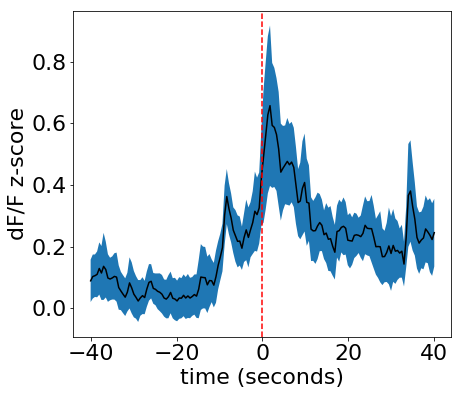

In [19]:
activity_measure = 'fluorescence'
x = np.linspace(-(len(df_to_plot)/2)*.5, (len(df_to_plot)/2)*.5, len(df_to_plot))
mean = df_to_plot.mean(axis=1, level=2)[activity_measure].values
plt.plot(x, mean, color='k')
std_error = (df_to_plot.std(axis=1, level=2)[activity_measure])/math.sqrt(df_to_plot.mean(axis=1, level=0).shape[1]*1)
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.set_ylabel('dF/F z-score')
ax.set_xlabel('time (seconds)')
ax.axvline(x=0, linestyle='--', color='r')
fig = plt.gcf()
fig.set_size_inches(7, 6)
#fig.draw()
#fig.savefig('.svg')
fig.subplots_adjust(left=0.15)
fig.savefig('/home/jma819/presentation_files/wt_fluorescence_triggered.pdf', transparent=True)
plt.show()

## look at individual cells 

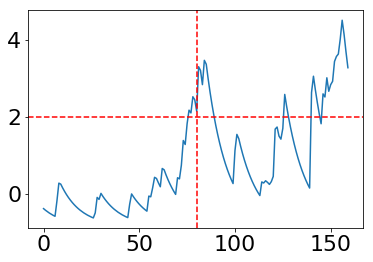

In [20]:
plt.plot(triggered_activity_across_cells['GRIN013_H13_M33_S54'][2042][4].values)
ax = plt.gca()
ax.axvline(x=80, linestyle='--', color='r')
ax.axhline(y=2, linestyle='--', color='r')
plt.show()

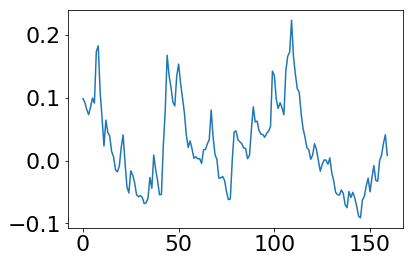

In [21]:
plt.plot(triggered_activity_across_cells.mean(axis=1))
plt.show()


In [22]:
test_region = pd.DataFrame(triggered_activity_across_cells.iloc[70:80]>2)

In [23]:
cells_active_before_crossing = [test_region.any().index[cell] for cell in range(len(triggered_activity_across_cells.columns)) if test_region.any()[cell]==True]

In [24]:
C_df

1         2         3         4    \
GRIN013_H13_M33_S54 00:00:00        -0.768173 -0.574279 -0.722104 -0.372751   
                    00:00:00.200000 -0.599276 -0.578764 -0.722104 -0.390512   
                    00:00:00.400000 -0.563105 -0.582632 -0.722104 -0.428853   
                    00:00:00.600000 -0.589768 -0.585968 -0.722104 -0.223408   
                    00:00:00.800000 -0.633146 -0.588844 -0.722104 -0.359708   
...                                       ...       ...       ...       ...   
GRIN035_H14_M40_S34 00:20:49        -0.199818 -0.316935  0.490162  0.144317   
                    00:20:49.200000 -0.265928 -0.347742  0.661186 -0.085060   
                    00:20:49.400000 -0.322677 -0.374401  0.583241 -0.259149   
                    00:20:49.600000 -0.371392 -0.397471  0.468999 -0.391275   
                    00:20:49.800000 -0.413209 -0.290268  0.364479 -0.491555   

                                          6         7         8         9    \
GRIN013_H13_M33_S54 00:00:00        -1.032938  0.160907 -0.838393 -0.739165   
                    00:00:00.200000 -1.032938  0.052372 -0.866799 -0.739165   
                    00:00:00.400000 -1.032938 -0.060226 -0.887089 -0.739165   
                    00:00:00.600000 -1.032938  0.398516 -0.901582 -0.739165   
                    00:00:00.800000 -1.032938  0.334636 -0.911934 -0.739165   
...                                       ...       ...       ...       ...   
GRIN035_H14_M40_S34 00:20:49        -0.232391 -0.463278 -0.392170 -0.432775   
                    00:20:49.200000 -0.233161 -0.463554 -0.395788 -0.433197   
                    00:20:49.400000 -0.233388 -0.463814 -0.398762 -0.432998   
                    00:20:49.600000 -0.233426 -0.464059 -0.401206 -0.433102   
                    00:20:49.800000 -0.233407 -0.464289 -0.403216 -0.433487   

                                          10        11   ...  164  165  166  \
GRIN013_H13_M33_S54 00:00:00        -0.177507 -0.515421  ...  NaN  NaN  NaN   
                    00:00:00.200000  0.020347 -0.538477  ...  NaN  NaN  NaN   
                    00:00:00.400000 -0.196176 -0.572586  ...  NaN  NaN  NaN   
                    00:00:00.600000  0.037987 -0.563779  ...  NaN  NaN  NaN   
                    00:00:00.800000 -0.062311 -0.577893  ...  NaN  NaN  NaN   
...                                       ...       ...  ...  ...  ...  ...   
GRIN035_H14_M40_S34 00:20:49              NaN -0.395097  ...  NaN  NaN  NaN   
                    00:20:49.200000       NaN -0.395102  ...  NaN  NaN  NaN   
                    00:20:49.400000       NaN -0.395108  ...  NaN  NaN  NaN   
                    00:20:49.600000       NaN -0.395113  ...  NaN  NaN  NaN   
                    00:20:49.800000       NaN -0.395119  ...  NaN  NaN  NaN   

                                     167  168  169  170       121  139  152  
GRIN013_H13_M33_S54 00:00:00         NaN  NaN  NaN  NaN       NaN  NaN  NaN  
                    00:00:00.200000  NaN  NaN  NaN  NaN       NaN  NaN  NaN  
                    00:00:00.400000  NaN  NaN  NaN  NaN       NaN  NaN  NaN  
                    00:00:00.600000  NaN  NaN  NaN  NaN       NaN  NaN  NaN  
                    00:00:00.800000  NaN  NaN  NaN  NaN       NaN  NaN  NaN  
...                                  ...  ...  ...  ...       ...  ...  ...  
GRIN035_H14_M40_S34 00:20:49         NaN  NaN  NaN  NaN -0.287997  NaN  NaN  
                    00:20:49.200000  NaN  NaN  NaN  NaN -0.294622  NaN  NaN  
                    00:20:49.400000  NaN  NaN  NaN  NaN -0.299409  NaN  NaN  
                    00:20:49.600000  NaN  NaN  NaN  NaN -0.302867  NaN  NaN  
                    00:20:49.800000  NaN  NaN  NaN  NaN -0.299318  NaN  NaN  

[82750 rows x 165 columns]

In [25]:
active_cells = list(set([(index[0], index[2]) for index in cells_active_before_crossing]))

In [26]:
len(active_cells)

72

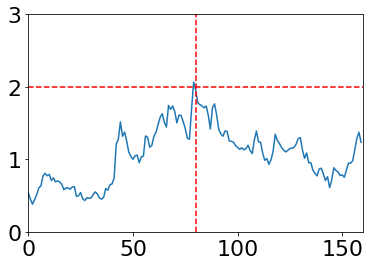

In [27]:
plt.plot(triggered_activity_across_cells[cells_active_before_crossing].mean(axis=1))
ax = plt.gca()
ax.axvline(x=80, linestyle='--', color='r')
ax.axhline(y=2, linestyle='--', color='r')
ax.set_xlim([0, 160])
ax.set_ylim([-0, 3])
plt.show()

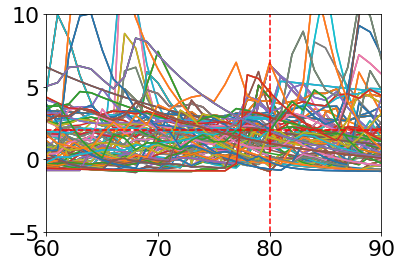

In [28]:
plt.plot(triggered_activity_across_cells[cells_active_before_crossing])
ax = plt.gca()
ax.axvline(x=80, linestyle='--', color='r')
ax.axhline(y=2, linestyle='--', color='r')
ax.set_xlim([60, 90])
ax.set_ylim([-5, 10])
plt.show()

In [29]:
len(list(set([cell[0] for cell in active_cells])))

9

In [30]:
## reconstruct videos of active cells

In [31]:
active_cell_dictionary = {}
for session in list(set([cell[0] for cell in active_cells])):
    active_cell_dictionary[session]=[]
for cell in active_cells:
    active_cell_dictionary[cell[0]].append(cell[1])
    

In [32]:
# save dictionary to file for loading later 
active_cell_dictionary
dictionary_output = csv.writer(open('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/indiv_cell_regressions/movement_initiation.csv', 'w'))
for key, val in active_cell_dictionary.items():
    dictionary_output.writerow([key, val])

# look at firing properties of movement initiating cells across velocity bins 

In [33]:
triggered_activity_across_cells.head()

GRIN013_H13_M33_S54                                                    \
                 2042                                                     
                  1         2         3         4         6         7     
0           -0.604431 -0.386081 -0.376406 -0.387892 -0.725667 -0.412920   
1           -0.645233 -0.423587 -0.380120 -0.429576 -0.474143 -0.535231   
2           -0.551471 -0.454721 -0.383795 -0.467473  0.055452 -0.620804   
3           -0.593384 -0.480565 -0.387430 -0.501926  0.052020 -0.680674   
4           -0.636938 -0.502019 -0.391026 -0.533248 -0.036219 -0.722562   

                                           ... GRIN035_H14_M40_S34            \
                                           ...                5643             
        8         9         10        11   ...                 109       110   
0 -0.724848 -0.651406 -0.080422 -0.489308  ...           -0.355370 -0.159648   
1 -0.745614 -0.653271 -0.155916 -0.503932  ...           -0.355611 -0.165050   
2 -0.764356 -0.655096 -0.223726 -0.517138  ...           -0.355996 -0.165201   
3 -0.781270 -0.656882 -0.284634 -0.529063  ...           -0.355847 -0.166235   
4 -0.796535 -0.658631 -0.339343 -0.329897  ...           -0.355969 -0.166503   

                                                                         \
                                                                          
        66        77        116       123       126       134       136   
0  0.173181 -0.666915 -0.504357  0.101069 -0.363351 -0.125688 -0.482262   
1  0.138387 -0.696073 -0.502304  0.522487 -0.374126 -0.125927 -0.510505   
2  0.100947 -0.677985 -0.497916  0.330221 -0.367452 -0.126114 -0.557951   
3  0.071680 -0.650050 -0.504097  0.029731 -0.365060 -0.126259 -0.595465   
4  0.048801 -0.683793 -0.515060 -0.065208 -0.366220 -0.126373 -0.625126   

             
             
        121  
0 -0.273488  
1 -0.279417  
2 -0.288668  
3 -0.287016  
4 -0.287802  

[5 rows x 4240 columns]

In [34]:
active_cell_dictionary 

{'GRIN035_H13_M31_S20': [1,
  85,
  6,
  27,
  14,
  7,
  76,
  10,
  94,
  3,
  28,
  36,
  39,
  17,
  4,
  35,
  29,
  25,
  56,
  71,
  5,
  8,
  67,
  23,
  92],
 'GRIN033_H13_M42_S33': [8,
  107,
  97,
  43,
  20,
  17,
  102,
  28,
  40,
  11,
  33,
  106,
  25,
  110],
 'GRIN027_H13_M29_S44': [23, 3, 14, 35, 32],
 'GRIN034_H16_M13_S22': [8],
 'GRIN034_H15_M28_S2': [2, 5, 19],
 'GRIN035_H13_M50_S58': [37, 23, 61, 156, 57, 143, 40, 49, 32],
 'GRIN035_H14_M40_S34': [48, 79],
 'GRIN013_H13_M33_S54': [16, 31, 4, 15, 22, 7, 21, 10, 17, 2],
 'GRIN033_H14_M34_S32': [28, 29, 19]}

In [35]:
V_df.head()

index  centroid  ear_right  \
GRIN013_H13_M33_S54 00:00:00         19.9575  1.024051   0.191429   
                    00:00:00.200000  25.9675  0.879805   0.192407   
                    00:00:00.400000  31.9775  0.735560   0.193386   
                    00:00:00.600000  37.9875  0.591315   0.194365   
                    00:00:00.800000  43.9975  0.447070   0.195343   

                                     miniscope_light  ear_left  tail_base  \
GRIN013_H13_M33_S54 00:00:00                3.920674  0.173353   0.137149   
                    00:00:00.200000         3.325429  0.173439   0.137967   
                    00:00:00.400000         2.730185  0.173524   0.138785   
                    00:00:00.600000         2.134941  0.173610   0.139603   
                    00:00:00.800000         1.539696  0.173695   0.140420   

                                     centroid_likelihood  \
GRIN013_H13_M33_S54 00:00:00                    0.590374   
                    00:00:00.200000             0.605093   
                    00:00:00.400000             0.619812   
                    00:00:00.600000             0.634532   
                    00:00:00.800000             0.649251   

                                     ear_right_likelihood  \
GRIN013_H13_M33_S54 00:00:00                     0.556108   
                    00:00:00.200000              0.602028   
                    00:00:00.400000              0.647949   
                    00:00:00.600000              0.693869   
                    00:00:00.800000              0.739789   

                                     miniscope_light_likelihood  \
GRIN013_H13_M33_S54 00:00:00                           0.000824   
                    00:00:00.200000                    0.000827   
                    00:00:00.400000                    0.000830   
                    00:00:00.600000                    0.000832   
                    00:00:00.800000                    0.000835   

                                     ear_left_likelihood  \
GRIN013_H13_M33_S54 00:00:00                    0.804563   
                    00:00:00.200000             0.817517   
                    00:00:00.400000             0.830471   
                    00:00:00.600000             0.843425   
                    00:00:00.800000             0.856379   

                                     tail_base_likelihood  msCam_index  \
GRIN013_H13_M33_S54 00:00:00                          1.0          3.0   
                    00:00:00.200000                   1.0          7.0   
                    00:00:00.400000                   1.0         11.0   
                    00:00:00.600000                   1.0         15.0   
                    00:00:00.800000                   1.0         19.0   

                                        velocity_bins  
GRIN013_H13_M33_S54 00:00:00         (-0.0114, 0.423]  
                    00:00:00.200000  (-0.0114, 0.423]  
                    00:00:00.400000  (-0.0114, 0.423]  
                    00:00:00.600000  (-0.0114, 0.423]  
                    00:00:00.800000  (-0.0114, 0.423]

In [36]:
C_df.head()

1         2         3         4    \
GRIN013_H13_M33_S54 00:00:00        -0.768173 -0.574279 -0.722104 -0.372751   
                    00:00:00.200000 -0.599276 -0.578764 -0.722104 -0.390512   
                    00:00:00.400000 -0.563105 -0.582632 -0.722104 -0.428853   
                    00:00:00.600000 -0.589768 -0.585968 -0.722104 -0.223408   
                    00:00:00.800000 -0.633146 -0.588844 -0.722104 -0.359708   

                                          6         7         8         9    \
GRIN013_H13_M33_S54 00:00:00        -1.032938  0.160907 -0.838393 -0.739165   
                    00:00:00.200000 -1.032938  0.052372 -0.866799 -0.739165   
                    00:00:00.400000 -1.032938 -0.060226 -0.887089 -0.739165   
                    00:00:00.600000 -1.032938  0.398516 -0.901582 -0.739165   
                    00:00:00.800000 -1.032938  0.334636 -0.911934 -0.739165   

                                          10        11   ...  164  165  166  \
GRIN013_H13_M33_S54 00:00:00        -0.177507 -0.515421  ...  NaN  NaN  NaN   
                    00:00:00.200000  0.020347 -0.538477  ...  NaN  NaN  NaN   
                    00:00:00.400000 -0.196176 -0.572586  ...  NaN  NaN  NaN   
                    00:00:00.600000  0.037987 -0.563779  ...  NaN  NaN  NaN   
                    00:00:00.800000 -0.062311 -0.577893  ...  NaN  NaN  NaN   

                                     167  168  169  170  121  139  152  
GRIN013_H13_M33_S54 00:00:00         NaN  NaN  NaN  NaN  NaN  NaN  NaN  
                    00:00:00.200000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
                    00:00:00.400000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
                    00:00:00.600000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
                    00:00:00.800000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 165 columns]

In [37]:
session_cells = {}
for session in list(active_cell_dictionary.keys()):
    session_cells[session] = C_df.loc[session][active_cell_dictionary[session]]

In [38]:
C_df_active_cells = pd.concat(session_cells)

In [39]:
C_df_active_cells['velocity_bins'] = all_sessions_v_bins

In [40]:
all_sessions_v_bins

GRIN013_H13_M33_S54  00:00:00           (-0.0114, 0.423]
                     00:00:00.200000    (-0.0114, 0.423]
                     00:00:00.400000    (-0.0114, 0.423]
                     00:00:00.600000    (-0.0114, 0.423]
                     00:00:00.800000    (-0.0114, 0.423]
                                              ...       
GRIN035_H14_M40_S34  00:22:17.200000      (0.801, 1.179]
                     00:22:17.400000      (0.801, 1.179]
                     00:22:17.600000      (0.801, 1.179]
                     00:22:17.800000      (0.801, 1.179]
                     00:22:18             (0.423, 0.801]
Name: tail_base, Length: 93958, dtype: category
Categories (150, interval[float64]): [(-0.0114, 0.423] < (0.423, 0.801] < (0.801, 1.179] < (1.179, 1.557] ... (55.238, 55.616] < (55.616, 55.995] < (55.995, 56.373] < (56.373, 56.751]]

In [41]:
## bin just active cells 

In [49]:
C_df_active_cells.unstack(level=0).swaplevel(axis=1)

,GRIN035_H13_M31_S20,GRIN033_H13_M42_S33,GRIN027_H13_M29_S44,GRIN034_H16_M13_S22,GRIN034_H15_M28_S2,GRIN035_H13_M50_S58,GRIN035_H14_M40_S34,GRIN013_H13_M33_S54,GRIN033_H14_M34_S32,GRIN035_H13_M31_S20,...,GRIN033_H14_M34_S32,GRIN035_H13_M31_S20,GRIN033_H13_M42_S33,GRIN027_H13_M29_S44,GRIN034_H16_M13_S22,GRIN034_H15_M28_S2,GRIN035_H13_M50_S58,GRIN035_H14_M40_S34,GRIN013_H13_M33_S54,GRIN033_H14_M34_S32
,1,1,1,1,1,1,1,1,1,85,...,21,velocity_bins,velocity_bins,velocity_bins,velocity_bins,velocity_bins,velocity_bins,velocity_bins,velocity_bins,velocity_bins
00:00:00,-0.735462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.539862,...,NaN,"(-0.0114, 0.423]","(-0.0114, 0.423]","(6.472, 6.85]","(-0.0114, 0.423]","(1.179, 1.557]","(1.557, 1.935]","(0.423, 0.801]","(-0.0114, 0.423]","(-0.0114, 0.423]"
00:00:00.200000,-0.735462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.552815,...,NaN,"(-0.0114, 0.423]","(-0.0114, 0.423]","(6.85, 7.228]","(-0.0114, 0.423]","(1.179, 1.557]","(3.448, 3.826]","(0.423, 0.801]","(-0.0114, 0.423]","(-0.0114, 0.423]"
00:00:00.400000,-0.735462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.562987,...,NaN,"(-0.0114, 0.423]","(-0.0114, 0.423]","(7.228, 7.606]","(-0.0114, 0.423]","(1.179, 1.557]","(5.338, 5.716]","(0.423, 0.801]","(-0.0114, 0.423]","(-0.0114, 0.423]"
00:00:00.600000,-0.735462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.570976,...,NaN,"(-0.0114, 0.423]","(-0.0114, 0.423]","(7.606, 7.984]","(-0.0114, 0.423]","(0.801, 1.179]","(7.606, 7.984]","(0.423, 0.801]","(-0.0114, 0.423]","(-0.0114, 0.423]"
00:00:00.800000,-0.735462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.572092,...,NaN,"(-0.0114, 0.423]","(-0.0114, 0.423]","(7.984, 8.362]","(-0.0114, 0.423]","(0.801, 1.179]","(9.496, 9.874]","(0.423, 0.801]","(-0.0114, 0.423]","(-0.0114, 0.423]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:23:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"(2.314, 2.692]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:23:19.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"(2.314, 2.692]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:23:19.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"(2.314, 2.692]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
